# Marché immobilier du Rhone

Objectif : 
... (rappel du sujet)
Comprendre les prix du marchés.
Dégager les tendances locales du marché.

Périmètre : 
pour les appartements du rhone (69)



Source de données : 
- Valeurs foncières (2016,...,2020)
    (documentation sur l'utilisation des données)
- Annonces scarppées (superimmo.com)
     joindre les dates et les secteurs scrappées.
     notamment ceux 
- outils :
    coordonnées gps des codes postaux:
    gradient colorimétrique.
    
préambule : 

Plan

1/ Analyse de la tendance local des prix pour les bien de même nature.
    A/ Recensement et analyse des données
    B/ gestion des outliers 
    C/ Calcul du prix moyen au metre carré, calcul de regression, 
    D/ datavix
2/ comparaison avec les données relevé sur le marché.
    extraction de features
3/ 


In [1]:
# requirements 
import pandas as pd
import folium
import seaborn as sns

# context
annees =  ['2016','2017','2018','2019','2020']
departement = 33                  # departement = 69
mapcenter = [44.837789, -0.57918] # mapcenter = [45.75, 4.85]


# 1/ Analyse de la tendance local des prix pour les bien de même nature.

In [3]:
# analyse pour sur les départements dont on a trouvé des annonces

tendance=pd.DataFrame()

# use dropbox for put dvf datas outside the project
dvf={
    '2016':'https://www.dropbox.com/s/zylo81u5shqhlor/valeursfoncieres-2016.txt?dl=1',
    '2017':'https://www.dropbox.com/s/mcq1h7vmrncp1eg/valeursfoncieres-2017.txt?dl=1',
    '2018':'https://www.dropbox.com/s/1hn2gcuvfeuzp5q/valeursfoncieres-2018.txt?dl=1',
    '2019':'https://www.dropbox.com/s/09k3ryk3id0wltk/valeursfoncieres-2019.txt?dl=1',
    '2020':'https://www.dropbox.com/s/k6ppasydb6mydut/valeursfoncieres-2020.txt?dl=1'
}

for annee in annees : 
    print(annee)
    df = pd.read_csv(dvf[annee],sep='|')
    
    df['annee']=annee
    # filtrage sur les critères qui nous intéresse..
    df = df[(df['Code departement']==departement)]
    df = df[(df['Nature mutation']=='Vente')&(df['Type local']=='Appartement')]
    
    # données inutilisables
    df = df[-(df['Valeur fonciere'].isna())]
    df = df[-(df['Surface reelle bati']==0)]
    
    # retrait des données trompeuses (voir la notice du dvf)
    multiple = df.groupby(['Valeur fonciere','Date mutation']).size()
    df['nb']=df.apply(lambda x: multiple[x['Valeur fonciere'],x['Date mutation']],axis=1)
    df = df[(df['nb']<2)]
    
    # valeurs déduites
    df['prix'] = df['Valeur fonciere'].apply(lambda x: int(float(str(x).replace(',','.'))))
    df['pm2'] = df.prix/df['Surface reelle bati']
    
    # seulement les données qui nous intéresse...
    fields=['annee','Valeur fonciere','Surface reelle bati','Code postal','Commune','Date mutation','prix','pm2']
    
    df=df[fields]
    
    tendance=pd.concat([tendance,df])

print(df)
print(df.columns)
# enregistrement des résultats.
# tendance.to_csv('datas/valeursfoncieres/valeursfoncieres-'+annees[0]+'-'+annees[-1]+'_'+str(departement)+'.csv')



2016


/Users/lfevre/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,23,24,26,28,30,31,32,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2017


/Users/lfevre/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2018


/Users/lfevre/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,23,24,26,28,29,31,32,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2019


/Users/lfevre/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,23,24,26,28,29,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


2020


/Users/lfevre/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (14,18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


       annee Valeur fonciere  Surface reelle bati  Code postal  \
645059  2020       254500,00                 81.0      33200.0   
645076  2020        15000,00                 66.0      33000.0   
645078  2020       183000,00                 35.0      33000.0   
645079  2020       110000,00                 42.0      33320.0   
645081  2020       215000,00                 37.0      33000.0   
...      ...             ...                  ...          ...   
736179  2020       124000,00                 30.0      33780.0   
736377  2020        77450,00                 38.0      33780.0   
736398  2020       141000,00                 61.0      33123.0   
736404  2020       104200,00                 23.0      33780.0   
736417  2020        71600,00                 29.0      33121.0   

                  Commune Date mutation    prix          pm2  
645059           BORDEAUX    10/01/2020  254500  3141.975309  
645076           BORDEAUX    09/01/2020   15000   227.272727  
645078           B

In [4]:
# Etude des données 
# tendance = pd.read_csv('datas/valeursfoncieres/valeursfoncieres-'+annees[0]+'-'+annees[-1]+'_'+str(departement)+'.csv',index_col=0)
tendance

,annee,Valeur fonciere,Surface reelle bati,Code postal,Commune,Date mutation,prix,pm2
881216,2016,"108000,00",28.0,33000.0,BORDEAUX,08/01/2016,108000,3857.142857
881222,2016,"220000,00",73.0,33520.0,BRUGES,06/01/2016,220000,3013.698630
881241,2016,"112000,00",27.0,33000.0,BORDEAUX,12/01/2016,112000,4148.148148
881243,2016,"95000,00",47.0,33200.0,BORDEAUX,08/01/2016,95000,2021.276596
881249,2016,"115750,00",95.0,33000.0,BORDEAUX,11/01/2016,115750,1218.421053
...,...,...,...,...,...,...,...,...
736179,2020,"124000,00",30.0,33780.0,SOULAC-SUR-MER,18/12/2020,124000,4133.333333
736377,2020,"77450,00",38.0,33780.0,SOULAC-SUR-MER,23/12/2020,77450,2038.157895
736398,2020,"141000,00",61.0,33123.0,LE VERDON SUR MER,23/12/2020,141000,2311.475410
736404,2020,"104200,00",23.0,33780.0,SOULAC-SUR-MER,30/12/2020,104200,4530.434783


In [5]:
# regroupement des données par commune et par an 
dbc=tendance[['annee','Commune','pm2']].groupby(['Commune','annee']).describe()
dbc

pm2                                        \
                         count         mean         std          min   
Commune            annee                                               
ABZAC              2016    1.0   823.529412         NaN   823.529412   
AILLAS             2020    1.0  4972.187500         NaN  4972.187500   
AMBARES-ET-LAGRAVE 2016   13.0  2097.386987  871.029241  1200.934579   
                   2017   19.0  2163.065569  637.673263  1417.238806   
                   2018   19.0  2219.518564  310.804434  1818.181818   
...                        ...          ...         ...          ...   
VIRSAC             2018    1.0  1777.777778         NaN  1777.777778   
                   2020    1.0  3400.000000         NaN  3400.000000   
YVRAC              2016    1.0  3020.000000         NaN  3020.000000   
                   2017    3.0  2220.456031  347.099325  1840.000000   
                   2019    1.0  3269.482759         NaN  3269.482759   

                                                                              
                                  25%          50%          75%          max  
Commune            annee                                                      
ABZAC              2016    823.529412   823.529412   823.529412   823.529412  
AILLAS             2020   4972.187500  4972.187500  4972.187500  4972.187500  
AMBARES-ET-LAGRAVE 2016   1660.714286  1866.666667  2089.285714  4400.000000  
                   2017   1644.648829  1956.521739  2496.861702  3444.444444  
                   2018   1998.640357  2109.375000  2360.528757  3039.344262  
...                               ...          ...          ...          ...  
VIRSAC             2018   1777.777778  1777.777778  1777.777778  1777.777778  
                   2020   3400.000000  3400.000000  3400.000000  3400.000000  
YVRAC              2016   3020.000000  3020.000000  3020.000000  3020.000000  
                   2017   2070.757576  2301.515152  2410.684046  2519.852941  
                   2019   3269.482759  3269.482759  3269.482759  3269.482759  

[727 rows x 8 columns]

In [7]:
# gestion des valeurs aberrantes
# la gestion et l'analyse des valeurs aberrantes doit étudier à part
# suppression des valeurs supérieurs à deux fois la mediane calculé 
def isoutlier(pm2,Commune,annee,dbc):
    return pm2>2*dbc.loc[(Commune,annee)]['pm2']['50%']
tendance['outlier']=df.apply(lambda x: isoutlier(x['pm2'],x['Commune'],x['annee'],dbc),axis=1)
tendance
tendance.outlier.value_counts()
# False    7988
# True      109
# Name: outlier, dtype: int64

# suppression des outliers
tendance = tendance[-(tendance['outlier']==True)]
tendance = tendance.drop(['outlier'], axis=1)

In [8]:
# sauvegarde des resultats
# tendance.to_csv('datas/valeursfoncieres/valeursfoncieres-'+annees[0]+'-'+annees[-1]+'_'+str(departement)+'_wo.csv')
# tendance = pd.read_csv('datas/valeursfoncieres/valeursfoncieres-'+annees[0]+'-'+annees[-1]+'_'+str(departement)+'_wo.csv',index_col=0)
tendance


,annee,Valeur fonciere,Surface reelle bati,Code postal,Commune,Date mutation,prix,pm2
881216,2016,"108000,00",28.0,33000.0,BORDEAUX,08/01/2016,108000,3857.142857
881222,2016,"220000,00",73.0,33520.0,BRUGES,06/01/2016,220000,3013.698630
881241,2016,"112000,00",27.0,33000.0,BORDEAUX,12/01/2016,112000,4148.148148
881243,2016,"95000,00",47.0,33200.0,BORDEAUX,08/01/2016,95000,2021.276596
881249,2016,"115750,00",95.0,33000.0,BORDEAUX,11/01/2016,115750,1218.421053
...,...,...,...,...,...,...,...,...
736179,2020,"124000,00",30.0,33780.0,SOULAC-SUR-MER,18/12/2020,124000,4133.333333
736377,2020,"77450,00",38.0,33780.0,SOULAC-SUR-MER,23/12/2020,77450,2038.157895
736398,2020,"141000,00",61.0,33123.0,LE VERDON SUR MER,23/12/2020,141000,2311.475410
736404,2020,"104200,00",23.0,33780.0,SOULAC-SUR-MER,30/12/2020,104200,4530.434783


In [15]:
# calcul global des coordonées gps
coo=pd.read_csv('databases/laposte_hexasmal.csv',sep=";")
# print(coo)
coo.Code_postal = coo.Code_postal.astype('str')
cpcoo={}
for cp,coo in zip (coo['Code_postal'].to_list(),coo['coordonnees_gps'].to_list()) :
    cpcoo[cp]=coo


def getcoo(x,cpcoo):       
    try :
        return cpcoo[x];
    except :
         return'0,0';
    

tendance['gps']=tendance['Code postal'].apply(lambda x: getcoo(str(int(float(x))),cpcoo))

# etudier les valeurs qui n'ont pas été trouvées
tendance = tendance[-(tendance.gps=='0,0')]

tendance

,annee,Valeur fonciere,Surface reelle bati,Code postal,Commune,Date mutation,prix,pm2,gps
881216,2016,"108000,00",28.0,33000.0,BORDEAUX,08/01/2016,108000,3857.142857,"44.8572445351,-0.57369678116"
881222,2016,"220000,00",73.0,33520.0,BRUGES,06/01/2016,220000,3013.698630,"44.8889469436,-0.600427664273"
881241,2016,"112000,00",27.0,33000.0,BORDEAUX,12/01/2016,112000,4148.148148,"44.8572445351,-0.57369678116"
881243,2016,"95000,00",47.0,33200.0,BORDEAUX,08/01/2016,95000,2021.276596,"44.8572445351,-0.57369678116"
881249,2016,"115750,00",95.0,33000.0,BORDEAUX,11/01/2016,115750,1218.421053,"44.8572445351,-0.57369678116"
...,...,...,...,...,...,...,...,...,...
736179,2020,"124000,00",30.0,33780.0,SOULAC-SUR-MER,18/12/2020,124000,4133.333333,"45.493296382,-1.10918123147"
736377,2020,"77450,00",38.0,33780.0,SOULAC-SUR-MER,23/12/2020,77450,2038.157895,"45.493296382,-1.10918123147"
736398,2020,"141000,00",61.0,33123.0,LE VERDON SUR MER,23/12/2020,141000,2311.475410,"45.5385656326,-1.07975440879"
736404,2020,"104200,00",23.0,33780.0,SOULAC-SUR-MER,30/12/2020,104200,4530.434783,"45.493296382,-1.10918123147"


In [29]:
# représentation graphique sur la carte de la tendance par commune de chaque commune.

#gradient40 = ['#fafa6e','#faf568','#f9f063','#f9eb5d','#f8e658','#f8e153','#f7dc4d','#f7d748','#f6d243','#f6cd3f','#f5c83a','#f4c335','#f4bd30','#f3b82c','#f2b327','#f1ae23','#f0a91f','#efa41b','#ee9e16','#ed9912','#ec940e','#eb8e0a','#ea8906','#e88303','#e77e01','#e67800','#e47300','#e36d00','#e16700','#df6100','#de5b00','#dc5501','#da4f02','#d84804','#d64105','#d43a07','#d23209','#d0290b','#cd1e0d','#cb0f0f',
#'#c5110f','#c0120f','#ba140f','#b5150f','#af1610','#aa1710','#a51710','#9f1810','#9a1810','#941910','#8f1910','#8a1910','#85190f','#80190f','#7a190f','#75190f','#70190f','#6b190f','#66190f','#61180e','#5c180e','#57180d','#53170d','#4e170d','#49160c','#44150b','#40150b','#3b140a','#371309','#321209','#2e1108','#291007','#250f06','#210d05','#1d0b04','#180903','#130603','#0b0402','#010101']
m = folium.Map(location=mapcenter)

gradient40 = []

gradient40 += ['#ffffff','#fffffa','#fffff5','#fffff0','#ffffeb','#ffffe6','#ffffe1','#ffffdc','#ffffd7','#ffffd2','#ffffce','#ffffc9','#ffffc4','#ffffbe','#ffffb9','#ffffb4','#ffffaf','#ffffaa','#ffffa5','#ffffa0','#ffff9b','#ffff95','#ffff90','#ffff8b','#ffff85','#ffff80','#ffff7a','#ffff74','#feff6f','#fdff69','#fdff62','#fcff5c','#fcff55','#fbff4e','#faff46','#f9ff3e','#f9ff35','#f8ff2a','#f7ff1b','#f6ff00']
gradient40 += ['#f6ff00','#f8fa00','#f9f600','#fbf100','#fcec00','#fee800','#ffe300','#ffde00','#ffd900','#ffd400','#ffd000','#ffcb00','#ffc600','#ffc100','#ffbc00','#ffb700','#ffb200','#ffad00','#ffa700','#ffa200','#ff9d00','#ff9800','#ff9200','#ff8d00','#ff8700','#ff8100','#ff7c00','#ff7600','#ff7000','#ff6a00','#ff6300','#ff5d00','#ff5600','#ff4f00','#ff4700','#ff3f00','#ff3500','#ff2a00','#ff1c00','#ff0303']
gradient40 += ['#ff0303','#fb0607','#f7090b','#f30c0f','#ee0e12','#ea1014','#e61316','#e21518','#de161a','#d9181c','#d51a1d','#d11b1e','#cd1c20','#c91e21','#c41f22','#c02023','#bc2124','#b72225','#b32325','#af2426','#aa2527','#a62527','#a22628','#9e2728','#992729','#952829','#91282a','#8c292a','#88292a','#842a2a','#7f2a2a','#7b2a2b','#772a2b','#722a2b','#6e2a2b','#692a2b','#652a2b','#612a2a','#5c2a2a','#582a2a','#582a2a','#562929','#552727','#532626','#522525','#502324','#4f2222','#4d2121','#4c1f20','#4a1e1f','#491d1e','#471c1c','#461a1b','#44191a','#431819','#421618','#401517','#3f1415','#3d1214','#3c1113','#3a1011','#390e10','#370d0e','#360c0c','#350a0a','#330908','#320806','#310604','#300501','#2f0300','#2e0100','#2d0000','#2c0000','#2b0000','#2a0000','#2a0000','#290000','#280000','#280000','#000000']

anneeRadius = {
    2016: 10,
    2017: 15,
    2018: 20,
    2019: 25,
    2020: 30
}

annees =  [2020,2019,2018,2017,2016]

for annee in annees : 
    tend = tendance[(tendance['annee']==str(annee))].groupby('Code postal').agg({'pm2' : ['mean'],'gps':['min'],'Commune':['min']})
    for gps,location,pm2 in zip (tend['gps']['min'].to_list(),tend['Commune']['min'].to_list(),tend['pm2']['mean'].to_list()) :
        folium.CircleMarker(
        location=gps.split(','),
        radius=anneeRadius[annee],
        popup=location+"("+str(annee)+") : "+str(pm2),
        color=gradient40[int(pm2/100)],
        fill=True,
        fill_color=gradient40[int(pm2/100)],
        ).add_to(m)

m 

In [30]:
# pd.crosstab(df.Commune, df.annee, values=df.pm2, aggfunc='mean')

# on négligera les communes ayant des valeurs manquantes 
pm2BcBy = pd.crosstab(tendance.Commune, tendance.annee, values=tendance.pm2, aggfunc='mean').dropna()
pm2BcBy

annee,2016,2017,2018,2019,2020
Commune,,,,,
AMBARES-ET-LAGRAVE,2097.386987,2163.065569,2219.518564,2212.006355,2703.379336
AMBES,2095.599562,2158.147546,1918.026577,1785.074627,1955.223881
ANDERNOS-LES-BAINS,3662.136331,3922.021742,4529.161227,5882.626609,5420.056414
ARCACHON,5046.444926,5427.817844,5867.416881,6455.943219,6690.377981
ARES,3234.687538,3608.136342,3590.437643,3638.933506,3390.015223
...,...,...,...,...,...
TARGON,2067.796610,1616.666667,1571.158009,1661.363636,2166.666667
TOULENNE,1316.492829,1482.769424,1461.238714,1684.615385,1876.053890
VAYRES,1398.967161,1692.592593,5387.786596,1954.012346,1730.358037


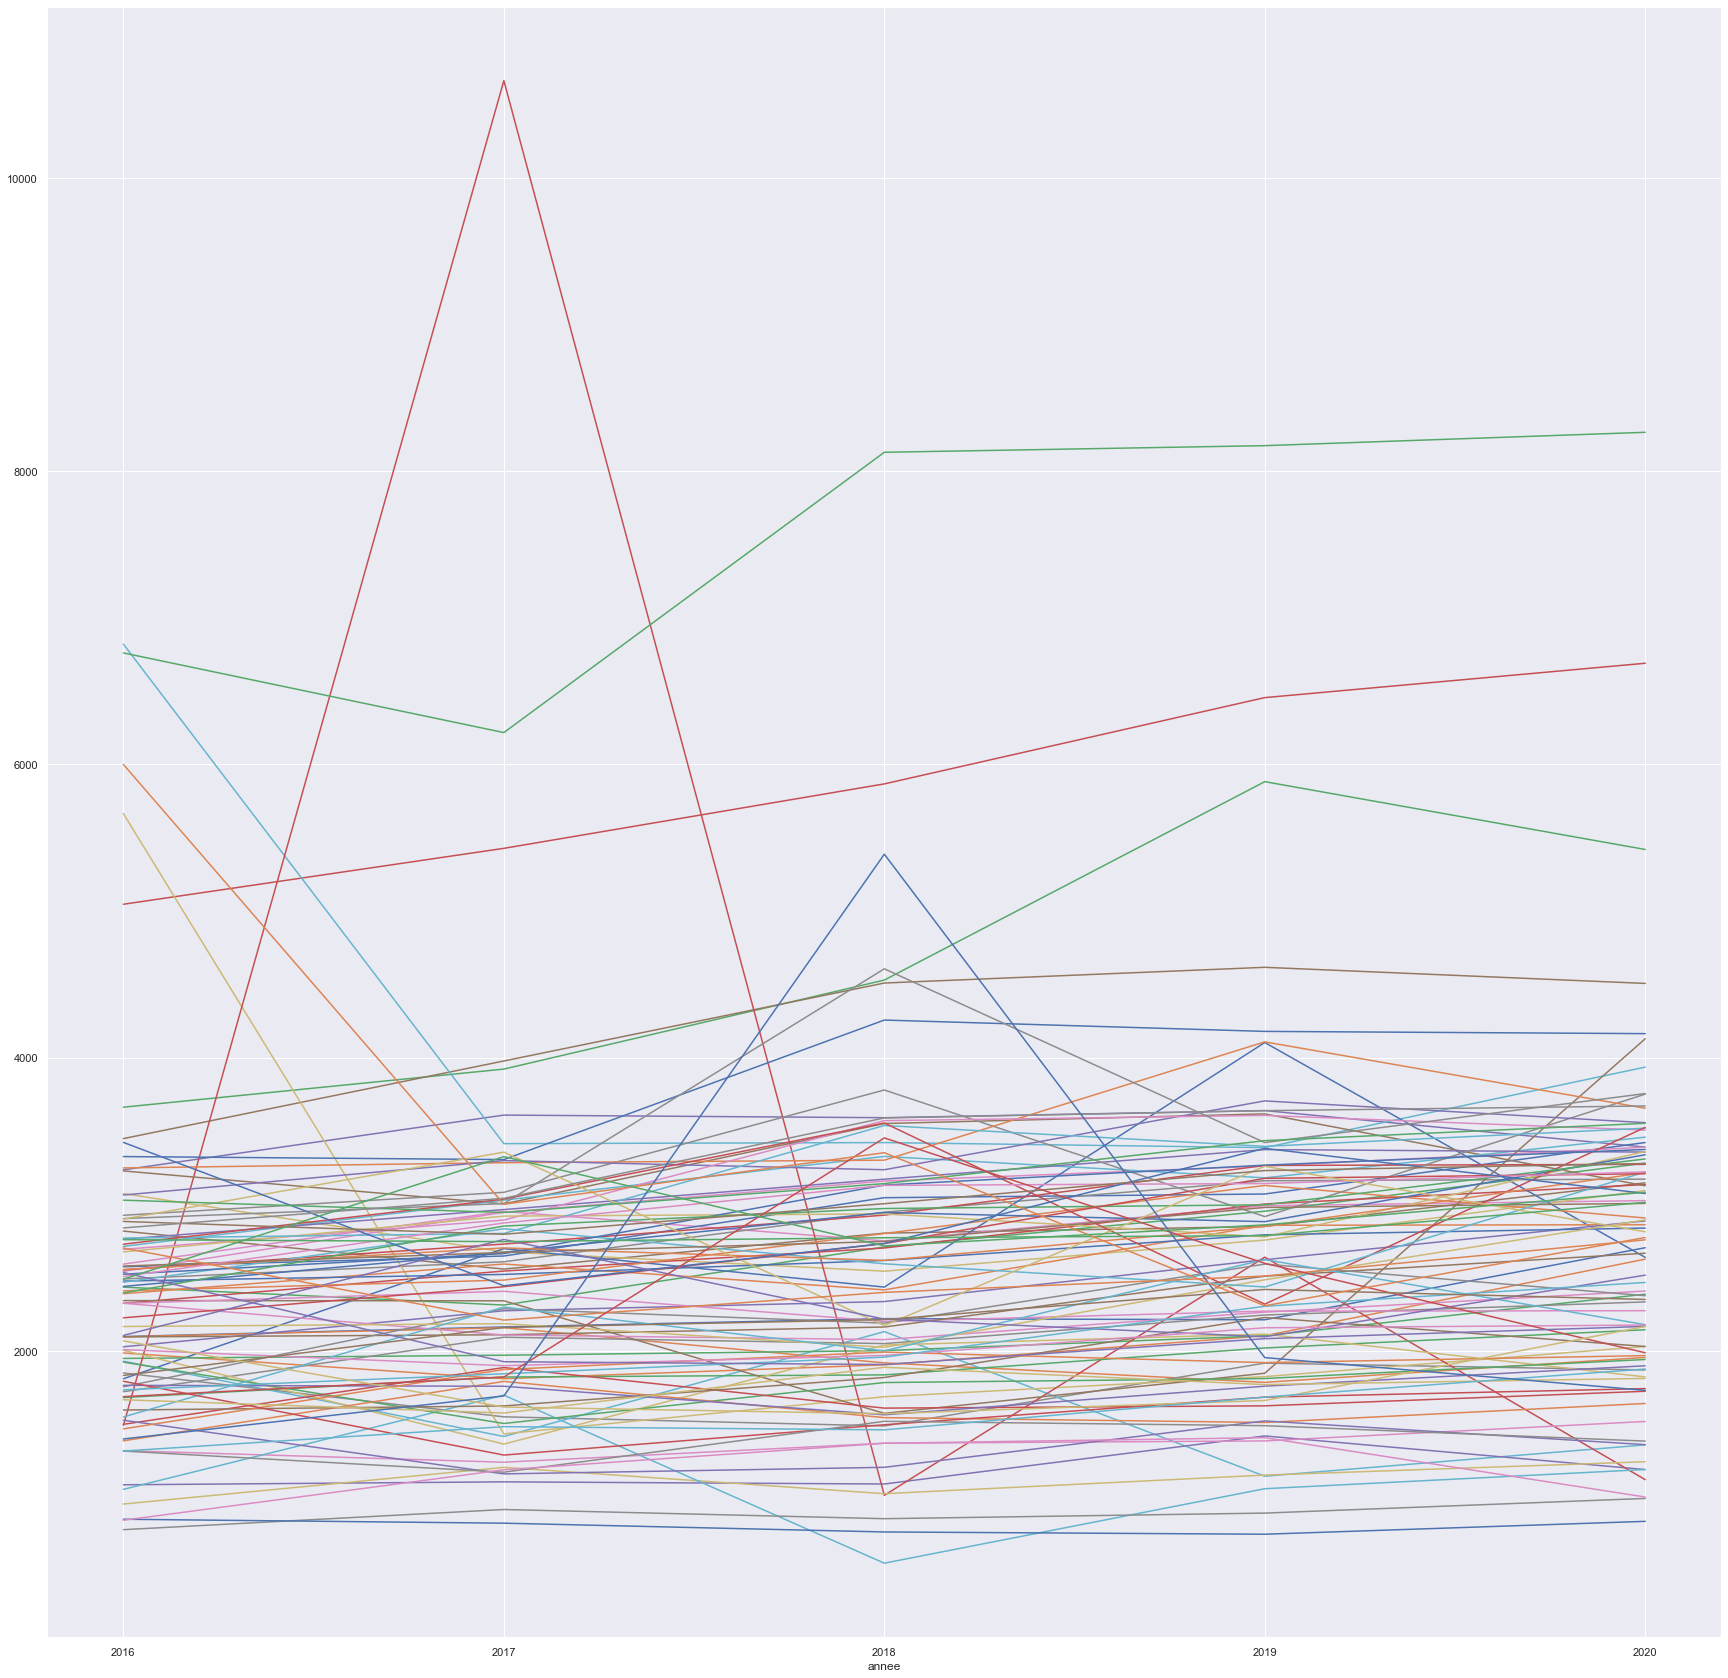

In [31]:
sns.set(rc={'figure.figsize':(30,30)})
for commune in pm2BcBy.index:
    sns.lineplot(x=pm2BcBy.loc[commune].index,y=pm2BcBy.loc[commune].values,data=pm2BcBy.loc[commune])

In [32]:
# faire un graphe avec bokeh pour plus de visibilité
# notamment pour savoir quelle commune est représentée par quel courbe
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
output_notebook()

hover = HoverTool(tooltips=[
            ("index", "$index"),
            ("commune", "$name"),
            ("pm2", "$y")])

p = figure(plot_width=1000, plot_height=1000, tools=[hover],
           title="Evolution du prix au mettre carré par commune du departement "+str(departement)+" depuis "+str(annees[0]))

for commune in pm2BcBy.index :
    p.line(x=pm2BcBy.loc[commune].index,y=pm2BcBy.loc[commune].values,name=commune)
show(p)

Loading BokehJS ...

In [ ]:
# à poursuivre avec l'integration des données scrappées 
# et intégrer d'autres données locales permettant d'expliquer la tendance.